In [5]:
import numpy as np
import pandas as pd
import spacy
import string
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
data_type = {"date": "string", "id": "string", "coordinates": "string", "full_text":"string", "sentiment": "int", "hashtags":"string"}
data = pd.read_csv("tweet_data.csv", dtype=data_type)
X, y = data["full_text"], data["sentiment"]

nlp = spacy.load('en')

def preprocess(text):
    words = nlp(text)
    tokens = [word.lemma_.lower() if word.lemma_ != '-PRON-' else word.lower_ for word in words]
    tokens = [t for t in tokens if t not in string.punctuation]
    return ' '.join(tokens)

X = pd.Series([preprocess(text) for text in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

train F1:         86.27%
train accuracy:   91.26%
test F1:          74.61%
test accuracy:    85.21%


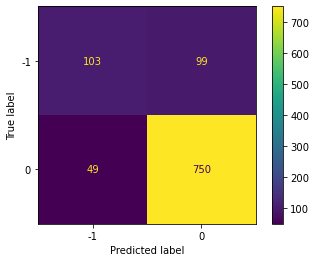

In [17]:
sample_weights = pd.Series(y_train)
sample_weights = sample_weights.replace({0: 0.4, -1: 1})

KEYWORDS = 'chinazi|chink|chingchong|gook|wuflu|wu flu|kungflu|kung flu'
slurs = X_train.str.contains(KEYWORDS, flags=re.IGNORECASE, regex=True)
for i, item in slurs.iteritems():
    if item:
        sample_weights.loc[i] = 1.3

# steps = [('tfidf', TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_df=0.4, min_df=3)), 
#          ('clf', MultinomialNB())]
steps = [('tfidf', TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_df=0.4, min_df=3)), 
         ('clf', SVC(kernel='sigmoid', C=10, gamma=0.1))]

model = Pipeline(steps)
model.fit(X_train, y_train, clf__sample_weight=sample_weights)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

def print_accuracy(name, test, pred):
    print("{:17} {:.4}%".format(name + " F1:", f1_score(test, pred, average='macro') * 100))
    print("{:17} {:.4}%".format(name + " accuracy:", accuracy_score(test, pred) * 100))
    
print_accuracy("train", y_train, y_train_pred)
print_accuracy("test", y_test, y_test_pred)

plot_confusion_matrix(model, X_test, y_test)

In [15]:
# save model
pickle.dump(model, open('clf.pickle', 'wb'))

In [41]:
# parameter tuning

# steps = [('tfidf', TfidfVectorizer()), 
#          ('clf', MultinomialNB())]
steps = [('tfidf', TfidfVectorizer(stop_words="english")), 
         ('clf', SVC(kernel='sigmoid', C=1, gamma=1))]

pipeline = Pipeline(steps)
parameters = {'tfidf__ngram_range': ((1,2),),
              'tfidf__max_df': (0.3, 0.4, 0.5, 0.6),
              'tfidf__min_df': (3, 5, 7),
              'clf__C': (0.01, 0.1, 1, 10, 100),
              'clf__gamma': (0.01, 0.1, 1, 10)}

clf = GridSearchCV(pipeline, parameters, verbose=1)
clf.fit(X_train, y_train, clf__sample_weight=sample_weights)

print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 21.2min finished


{'clf__C': 100, 'clf__gamma': 0.01, 'tfidf__max_df': 0.3, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
0.8264232209737828
